In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

# Import train and test split functions
from sklearn.model_selection import train_test_split

# Import Bert tokenizer and transformer
from transformers import BertTokenizerFast

import datasets

# Import Trainer
from transformers import Trainer, TrainingArguments

# Import pytorch
import torch
# Import dataset and dataloader
from torch.utils.data import Dataset


# Import tensorboard for logging
from torch.utils.tensorboard import SummaryWriter
writer_path = os.path.join('./tensorboard_logs')
writer = SummaryWriter(writer_path)


from tqdm import tqdm


In [ ]:
# Download data from source
!gdown 1RX3DgPDdVv8wXg43L2tzV6eAJvG7OgkY

In [2]:
# Load data
df = pd.read_csv('final_feature_data.csv', index_col=0)
df.head()

,user_id,post_body,post_title,cleaned_body,cleaned_title,title_length,post_length,sad,labels,negative_cnt2,suicidal_degree,number_of_posts
0,16,I'm stuck and I hate it. I have zero confidenc...,I can't see another way out. Nothing is workin...,stuck hate confidence abilities future stuck d...,working sliding back,7.0,100.0,0.593416,1.0,1.945910,1.426405,2.0
1,706,_URL_ Please head over to this link.He needs h...,I don't know what else to do...[Please help],url head link figured professional give hope r...,NaN,8.0,56.0,0.000000,0.0,0.000000,1.278830,1.0
2,981,I don't know. I've always had depression. Some...,Point of Existence,depression worse worse moved country year ago ...,point existence,3.0,325.0,0.463558,0.0,2.890372,1.420861,1.0
3,1233,[15 M] I only stay around because I'm afraid m...,I just want to be happy again...,stay afraid friend kill care make killing read...,happy,7.0,111.0,0.210069,1.0,1.791759,1.224538,1.0
4,1318,"So um, hey everyone.I'm not sure really what t...",Referred here by someone on a forum...,um hey put depression issues long time yay pub...,referred forum,7.0,185.0,0.390625,1.0,2.197225,1.483701,1.0


/home/nagas/.conda/envs/641/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


107.06498194945848 189.84790661501842


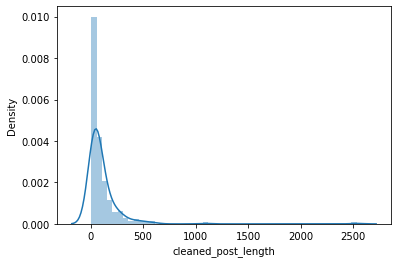

In [3]:
df['cleaned_post_length'] = df['cleaned_body'].apply(lambda x: len(x.split(' ')))
# Plot the distribution of post length
sns.distplot(df['cleaned_post_length'])
# Print mean and std of post length
print(df['cleaned_post_length'].mean(), df['cleaned_post_length'].std())

In [4]:
# Find mean and std of post length
df['cleaned_post_length'].describe()

count     277.000000
mean      107.064982
std       189.847907
min         6.000000
25%        30.000000
50%        55.000000
75%       119.000000
max      2534.000000
Name: cleaned_post_length, dtype: float64

In [5]:
# Drop missing values
df.dropna(inplace=True)

In [7]:
# Perform train/valid/test split with stratified sampling
X = df.drop(['labels'], axis=1)
y = df.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Print the size of the train, valid, and test sets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 165
Validation set size: 42
Test set size: 52


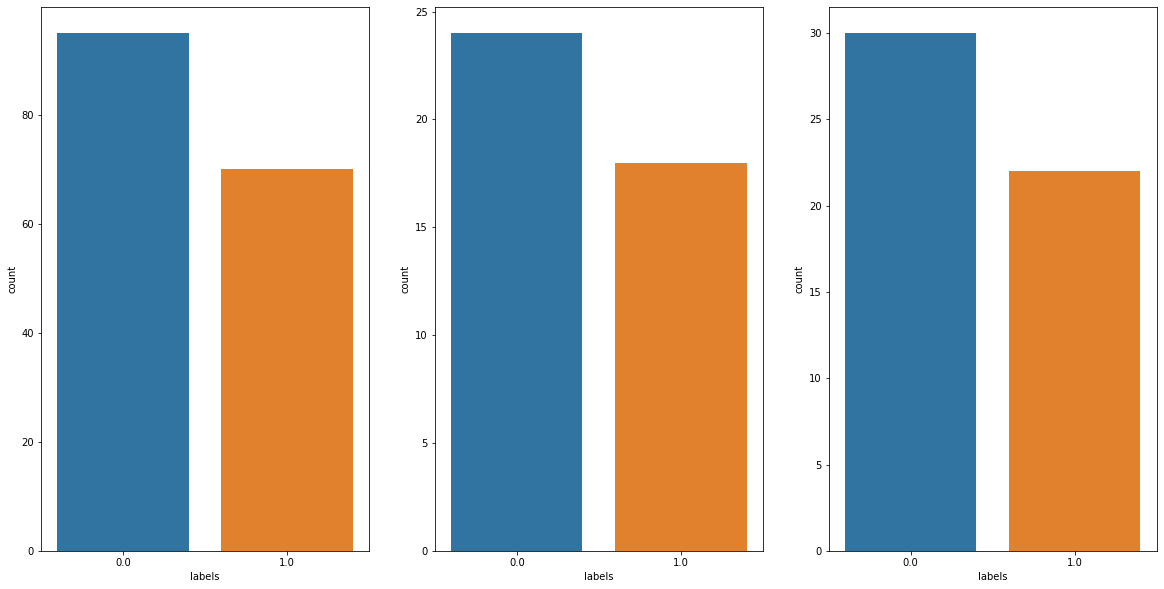

In [8]:
# Show distribution of labels in train, valid, and test sets
# Display plots next to each other
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
sns.countplot(x=y_train, data=X_train)
plt.subplot(1, 3, 2)
sns.countplot(x=y_val, data=X_val)
plt.subplot(1, 3, 3)
sns.countplot(x=y_test, data=X_test)
plt.show()

In [130]:
# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', fast

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /home/nagas/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /home/nagas/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/nagas/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c3

In [137]:
# Creating Data Sets

# Create Encoders using BertTokenizer
train_encodings = tokenizer(
    X_train['cleaned_body'].tolist(),
    padding=True,
    max_length = 90,
    truncation=True,
    return_token_type_ids=False,
    # return_tensors='pt',
)
val_encodings = tokenizer(
    X_val['cleaned_body'].tolist(),
    padding=True,
    max_length = 90,
    truncation=True,
    return_token_type_ids=False,
    # return_tensors='pt',
)

# Create dataset class
class BertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {
            k: torch.tensor(v[idx]) for k, v in self.encodings.items()
        }
        item['labels'] = torch.tensor(int(self.labels.iloc[idx]))


        return item

train_dataset = BertDataset(train_encodings, y_train)
val_dataset = BertDataset(val_encodings, y_val)


In [132]:
# Model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=2, 
    output_hidden_states=False, 
    output_attentions=False
)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {pytorch_total_params}')

# Set device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model.to(device)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/nagas/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from 

Total number of parameters: 109483778


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [148]:
# Use TrainingArguments and Trainer
training_args = TrainingArguments(
    output_dir='./models/bert',
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=20,
    num_train_epochs=4,
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    weight_decay=0.01,
    adam_epsilon=1e-06,
    max_grad_norm=1.0,
    warmup_steps=500,
)

metric = datasets.load_metric('accuracy')

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.argmax(-1)
    return metric.compute(references=preds,predictions=labels)
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [149]:
# Train model
trainer.train()

/home/nagas/.conda/envs/641/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 165
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Epoch,Training Loss,Validation Loss,Accuracy
1,0.652100,0.694758,{'accuracy': 0.5238095238095238}
2,0.652100,0.693986,{'accuracy': 0.5714285714285714}


***** Running Evaluation *****
  Num examples = 42
  Batch size = 32
Trainer is attempting to log a value of "{'accuracy': 0.5238095238095238}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./models/bert/checkpoint-6
Configuration saved in ./models/bert/checkpoint-6/config.json
Model weights saved in ./models/bert/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 42
  Batch size = 32
Trainer is attempting to log a value of "{'accuracy': 0.5714285714285714}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./models/bert/checkpoint-12
Configuration saved in ./models/bert/checkpoint-12/config.json
Model weights saved in ./models/bert/checkpoint-12/pytorch_model.bin


TypeError: '>' not supported between instances of 'dict' and 'dict'

In [ ]:
# Training loop
def train(model, train_dataloader, val_dataloader, optimizer, learning_rate_scheduler, num_epochs, device):
    # Set device
    model.to(device)

    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        
        
        ######## TRAINING #########        

        # Set model to training mode
        model.train()

        # Set traingin loss and accuracy to 0
        train_accuracy = 0
        train_loss = 0

        for data in train_dataloader:

            # Set the gradients to zero for each batch
            model.zero_grad()

            # Set the input and labels to the device by getting to right dimension
            input_ids= data['input_ids'].squeeze(1).to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            # Forward pass
            batch_loss, logits = model(
                input_ids=input_ids, 
                token_type_ids=None,
                attention_mask=attention_mask,
                labels=labels
            )
            
            # Add loss to total loss
            train_loss += batch_loss.item()

            # Backward pass
            batch_loss.backward()

            # Clip the gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update weights
            optimizer.step()

            # Update scheduler
            learning_rate_scheduler.step()

            # Get the training accuracy
            _, predicted = torch.max(logits.data, 1)
            train_accuracy += (predicted == labels).sum().item()


        # Calculate average loss and accuracy
        avg_loss = train_loss / len(train_dataloader)
        avg_accuracy = train_accuracy / len(train_dataloader)

        # Add to tensorboard
        writer.add_scalar('train/Loss', avg_loss, epoch)
        writer.add_scalar('train/Accuracy', avg_accuracy, epoch)

        # Add loss and accuracy to lists
        train_losses.append(avg_loss)
        train_accuracies.append(avg_accuracy)


        ######## VALIDATION #########

        # Set model to evaluation mode
        model.eval()

        # Calculate validation accuracy and loss to 0
        val_accuracy = 0
        val_loss = 0
        
        for data in train_dataloader:
            
            # Set the input and labels to the device by getting to right dimension
            input_ids= data['input_ids'].squeeze(1).to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            with torch.no_grad():
                # Forward pass
                batch_loss, logits = model(
                    input_ids=input_ids, 
                    token_type_ids=None,
                    attention_mask=attention_mask,
                    labels=labels
                )

            # Add loss to total loss
            val_loss += batch_loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Calculate accuracy            
            val_accuracy += get_accuracy(logits, labels)
            
        # Calculate average loss and accuracy
        avg_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = val_accuracy / len(val_dataloader)

        # Add to tensorboard
        writer.add_scalar('valid/Loss', avg_loss, epoch)
        writer.add_scalar('valid/Accuracy', avg_val_accuracy, epoch)

        # Add validation accuracy and loss to lists
        val_accuracies.append(avg_val_accuracy)
        val_losses.append(avg_loss)

    # Print the results
    print(f'Training Loss: {avg_loss}')
    print(f'Training Accuracy: {avg_accuracy}')
    print(f'Validation Accuracy: {avg_val_accuracy}')
    print('\n')

    # Return the model and the lists
    return model, accuracies, losses, val_accuracies

In [ ]:
# Training
classifier, accuracies, losses, val_accuracies = train(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    learning_rate_scheduler,
    num_epochs,
    device
)

In [ ]:
# Save the model to a file
torch.save(classifier.state_dict(), './model.pth')

In [ ]:
# From the saved model, load the model
classifier.load_state_dict(torch.load('./model.pth'))

In [ ]:
# Plot the results from the loaded model
plt.plot(accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()
plt.plot(losses, label='Training Loss')
plt.legend()
plt.show()

In [ ]:
# Close the tensorboard writer
writer.close()